# Quantum Stock Picking and Quantum Portfolio Optimization


In [1]:
#6005eb03472e63b11e2ee077908d91cdcc1e6566461263fe6bb57b63de174c369b5ddbe0c5d42fcbf7330a6f6612e1bd833c3ddcf1e15fb4e960a117dc13cd11

## Introduction

This assignment will shows how we can use mean-variance optimization to pick stocks for a problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
[Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.](https://arxiv.org/abs/1907.04769)

Note: We are not using CVaR as a portfolio statistic here, rather as a heuristic in our VQE procedure, curious students are encouraged to read the paper above.

#### To Students: Complete the following sections labeled todo

In [3]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas
import pandas as pd

def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [4]:
from qiskit import IBMQ
IBMQ.save_account('6005eb03472e63b11e2ee077908d91cdcc1e6566461263fe6bb57b63de174c369b5ddbe0c5d42fcbf7330a6f6612e1bd833c3ddcf1e15fb4e960a117dc13cd11', overwrite=True)

In [4]:
#IBMQ.providers()[0].backends()[-1]

In [5]:
#global random seed used throuhgout
seed = 123

In [6]:
# Generate expected return and covariance matrix from (random) time-series

#Todo pick candidate stocks, 3-8 are recommended, stick to 4 if you're going to submit a real quantum experiment to IBM's cloud:

stocks = ['IBM','MSFT','GOOGL','AMZN','BABA']

# Here are some quantum themed stocks :) 
# ['IBM','AMD','ACN','NVDA','GOOGL','MSFT','AMZN','MU','BABA']
# Feel free to pick any in this list or beyond
    
num_assets = len(stocks)

#IBM has done us a favour and provided a cute data provider they designed.
data = YahooDataProvider(tickers=stocks,
                 start=pandas.Timestamp('2015'),
                 end=pandas.Timestamp.now())
data.run()

# Here we pull apart the IBM qiskit_finance.data_provider internals to retreive our data and format as a pandas DataFrame
df = pandas.DataFrame({data._tickers[tidx]:data._data[tidx] for tidx in range(len(data._tickers))})

# Provided by IBM
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [7]:
q = 0.50                   #  risk appetite 
budget = num_assets  //2   #  stocks to allocate
penalty = num_assets       #  set parameter to scale the budget penalty term
bounds = None              #  Allocation percent: None: 100%

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,bounds=bounds)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000143007918 x_0 - 0.001326151363 x_1 - 0.001102865871 x_2
      - 0.001554990852 x_3 - 0.000284165007 x_4 + [ 0.000245765391 x_0^2
      + 0.000265982611 x_0*x_1 + 0.000237944485 x_0*x_2 + 0.000189486072 x_0*x_3
      + 0.000187919936 x_0*x_4 + 0.000288217789 x_1^2 + 0.000412109400 x_1*x_2
      + 0.000417966709 x_1*x_3 + 0.000327982423 x_1*x_4 + 0.000278967925 x_2^2
      + 0.000406657086 x_2*x_3 + 0.000321640348 x_2*x_4 + 0.000361323355 x_3^2
      + 0.000360702247 x_3*x_4 + 0.000478777494 x_4^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End

## Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [9]:
algorithm_globals.random_seed = seed+1
backend = Aer.get_backend('statevector_simulator')

#backend = IBMQ.providers()[0].backends()[-1]
cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)


# print(result.fval)
print_result(result)

Optimal: selection [0. 1. 0. 1. 0.], value -0.0023

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1]	-0.0008		0.5791
[0 1 1 0 0]	-0.0019		0.4141
[1 1 0 0 0]	-0.0011		0.0020
[0 1 0 1 0]	-0.0023		0.0016
[0 0 0 1 1]	-0.0012		0.0014
[1 0 0 0 1]	0.0000		0.0007
[0 1 0 0 1]	-0.0011		0.0007
[1 0 1 0 1]	1.0061		0.0001
[1 1 1 0 0]	1.0051		0.0001
[1 0 1 0 0]	-0.0009		0.0001
[1 1 0 0 1]	1.0059		0.0000
[1 0 0 1 1]	1.0057		0.0000
[1 1 0 1 0]	1.0047		0.0000
[1 0 0 0 0]	1.0068		0.0000
[0 0 0 1 0]	1.0054		0.0000
[1 1 1 1 0]	4.0246		0.0000
[1 0 1 1 1]	4.0257		0.0000
[0 1 0 1 1]	1.0048		0.0000
[0 0 1 1 0]	-0.0021		0.0000
[1 0 0 1 0]	-0.0013		0.0000
[1 1 1 0 1]	4.0259		0.0000
[0 0 1 1 1]	1.0050		0.0000
[0 1 1 0 1]	1.0051		0.0000
[0 0 1 0 0]	1.0058		0.0000
[1 0 1 1 0]	1.0049		0.0000
[1 1 1 1 1]	9.0592		0.0000
[0 1 1 1 1]	4.0248		0.0000
[0 1 0 0 0]	1.0056		0.0000
[0 0 0 0 0]	4.0272		0.0000
[1 1 0 1 1]	4.0255		0.0

In [9]:
#result.x

In [10]:
#stocks
df

,IBM,MSFT,GOOGL,AMZN,BABA
Date,,,,,
2015-01-02,114.906525,41.193836,529.549988,308.519989,103.599998
2015-01-05,113.098465,40.815025,519.460022,302.190002,101.000000
2015-01-06,110.659370,40.215969,506.640015,295.290009,103.320000
2015-01-07,109.936157,40.726933,505.149994,298.420013,102.129997
2015-01-08,112.325630,41.925037,506.910004,300.459991,105.029999
...,...,...,...,...,...
2021-11-29,118.500000,336.630005,2910.610107,3561.570068,131.610001
2021-11-30,117.099998,330.589996,2837.949951,3507.070068,127.529999
2021-12-01,116.919998,330.079987,2821.030029,3443.719971,122.489998


In [11]:
#np.array(stocks)[result.x.astype('bool')]

In [11]:
selected_stocks = list(np.array(stocks)[result.x.astype('bool')])
print(f"Stocks from our Qunatum Stock Picking algorthm selected: {selected_stocks}")

Stocks from our Qunatum Stock Picking algorthm selected: ['MSFT', 'AMZN']


### Student todo, complete an equity curve, CAGR and IR comparison for the portfolio of all the stocks you selected for optimization compared to one which your Quantum Stock picker put together

hints:


df[selected_stocks] contains a data frame with your stock pick prices.   
df is the full list of stocks you started with.

IR selection: 1.4
IR all: 1.01 

CAGR selection: 270.47%
CAGR all: 116.85%


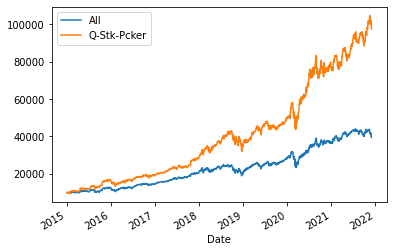

In [12]:
all_df = df
sel_df = df[selected_stocks]


sel_df_dr = sel_df.pct_change().dropna().mean(axis= 1)
all_df_dr = all_df.pct_change().dropna().mean(axis= 1)

eq_sel = 10000*sel_df_dr.add(1).cumprod()
eq_all = 10000*all_df_dr.add(1).cumprod()


eq_all.plot()
eq_sel.plot()
plt.legend(['All','Q-Stk-Pcker'])

IR_sel = (sel_df_dr.mean() / sel_df_dr.std()) * (252) ** 0.5

IR_all = (all_df_dr.mean() / all_df_dr.std()) * (252) ** 0.5
                
print(f"IR selection: {round(IR_sel,2)}")
print(f"IR all: {round(IR_all,2)} \n")

CAGR_all = 100*((eq_all.iloc[-1]/10000)-1) ** (252/len(eq_all))                 
CAGR_sel = 100*((eq_sel.iloc[-1]/100)-1) ** (252/len(eq_sel)) 

                
print(f"CAGR selection: {round(CAGR_sel,2)}%")
print(f"CAGR all: {round(CAGR_all,2)}%")

In [14]:
#eq_all
#(all_df * 10000).plot()
#(10000*all_df_dr.add(1).cumprod()).plot()

In [13]:
df

,IBM,MSFT,GOOGL,AMZN,BABA
Date,,,,,
2015-01-02,114.906525,41.193836,529.549988,308.519989,103.599998
2015-01-05,113.098465,40.815025,519.460022,302.190002,101.000000
2015-01-06,110.659370,40.215969,506.640015,295.290009,103.320000
2015-01-07,109.936157,40.726933,505.149994,298.420013,102.129997
2015-01-08,112.325630,41.925037,506.910004,300.459991,105.029999
...,...,...,...,...,...
2021-11-29,118.500000,336.630005,2910.610107,3561.570068,131.610001
2021-11-30,117.099998,330.589996,2837.949951,3507.070068,127.529999
2021-12-01,116.919998,330.079987,2821.030029,3443.719971,122.489998


# (Optional) For Advanced Students:

## Here we will make some modifications to do portfolio optimization


This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{j ... k\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{-j, +k\}^n$ denotes the vector of weight allocation variables, which indicate the relative allocation to assign. 
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to allocate exactly $B$ relative amounts of asset.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This rest of this notebook shows how to use the Variational Quantum Eigensolver (VQE) an optimal solution for a given set of parameters.

In [14]:
q = 0.50                   #  risk appetite 
budget = num_assets        #  Units to allocate
penalty = num_assets //2   #  set parameter to scale the budget penalty term
bounds =[(-1,2)] *num_assets #  Allocation units, can be negative or positive


portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,bounds=bounds)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000143007918 x_0 - 0.001326151363 x_1 - 0.001102865871 x_2
      - 0.001554990852 x_3 - 0.000284165007 x_4 + [ 0.000245765391 x_0^2
      + 0.000265982611 x_0*x_1 + 0.000237944485 x_0*x_2 + 0.000189486072 x_0*x_3
      + 0.000187919936 x_0*x_4 + 0.000288217789 x_1^2 + 0.000412109400 x_1*x_2
      + 0.000417966709 x_1*x_3 + 0.000327982423 x_1*x_4 + 0.000278967925 x_2^2
      + 0.000406657086 x_2*x_3 + 0.000321640348 x_2*x_4 + 0.000361323355 x_3^2
      + 0.000360702247 x_3*x_4 + 0.000478777494 x_4^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 = 5

Bounds
 -1 <= x_0 <= 2
 -1 <= x_1 <= 2
 -1 <= x_2 <= 2
 -1 <= x_3 <= 2
 -1 <= x_4 <= 2

Generals
 x_0 x_1 x_2 x_3 x_4
End

In [15]:
algorithm_globals.random_seed = seed +1
backend = Aer.get_backend('statevector_simulator')


cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",
/opt/conda/lib/python3.8/site-packages/qiskit_optimization/algorithms/optimization_algorithm.py:141: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


In [18]:
allocations = pandas.DataFrame({f"{stocks[tidx]}":result.x[tidx] for tidx in range(len(stocks))},index=['Allocation'])
allocations

,IBM,MSFT,GOOGL,AMZN,BABA
Allocation,1.0,2.0,0.0,2.0,0.0


### Student todo, complete an equity curve, CAGR and IR comparison for the a portfolio of all the stocks you selected for optimization compared to one which your Quantum Portfolio Optimzer put together.

hints:


The variable allocations contains a DataFrame with your relative stock allocations.   
df is the full list of stocks you started with.

In [21]:
port = df.pct_change().dropna()
port

,IBM,MSFT,GOOGL,AMZN,BABA
Date,,,,,
2015-01-05,-0.015735,-0.009196,-0.019054,-0.020517,-0.025097
2015-01-06,-0.021566,-0.014677,-0.024679,-0.022833,0.022970
2015-01-07,-0.006535,0.012705,-0.002941,0.010600,-0.011518
2015-01-08,0.021735,0.029418,0.003484,0.006836,0.028395
2015-01-09,0.004355,-0.008405,-0.012211,-0.011749,-0.019137
...,...,...,...,...,...
2021-11-29,0.023228,0.021081,0.023544,0.016267,-0.013048
2021-11-30,-0.011814,-0.017943,-0.024964,-0.015302,-0.031001
2021-12-01,-0.001537,-0.001543,-0.005962,-0.018064,-0.039520


In [30]:
portfolio = (port*allocations.values).mean(axis=1)
portfolio

Date
2015-01-05   -0.015032
2015-01-06   -0.019317
2015-01-07    0.008015
2015-01-08    0.018849
2015-01-09   -0.007191
                ...   
2021-11-29    0.019585
2021-11-30   -0.015661
2021-12-01   -0.008150
2021-12-02   -0.001488
2021-12-03   -0.010083
Length: 1743, dtype: float64

In [31]:
portfolio = (port*allocations.values).mean(axis=0)
portfolio

IBM      0.000143
MSFT     0.002652
GOOGL    0.000000
AMZN     0.003110
BABA     0.000000
dtype: float64